In [3]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import random
import numpy as np

from keras_unet_collection import models

from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

ModuleNotFoundError: No module named 'tensorflow.keras'

In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:18<00:00, 46.39it/s]


In [2]:
from tensorflow.keras import layers, models

def unet_plus_plus(tamanho_entrada=(512, 512, 1)):
    entradas = layers.Input(tamanho_entrada)
    
    # Função para blocos de convolução
    def conv_block(x, filtros, nome):
        x = layers.Conv2D(filtros, (3, 3), activation='relu', padding='same', name=nome+'_conv1')(x)
        x = layers.Conv2D(filtros, (3, 3), activation='relu', padding='same', name=nome+'_conv2')(x)
        return x
    
    # Codificador
    c1 = conv_block(entradas, 16, 'c1')
    p1 = layers.MaxPooling2D((2, 2), name='p1')(c1)

    c2 = conv_block(p1, 32, 'c2')
    p2 = layers.MaxPooling2D((2, 2), name='p2')(c2)

    c3 = conv_block(p2, 64, 'c3')
    p3 = layers.MaxPooling2D((2, 2), name='p3')(c3)

    c4 = conv_block(p3, 128, 'c4')
    p4 = layers.MaxPooling2D((2, 2), name='p4')(c4)

    c5 = conv_block(p4, 256, 'c5')

    # Decodificador com conexões densas (U-Net++)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='u6')(c5)
    u6 = layers.concatenate([u6, c4], axis=3, name='concat6')
    c6 = conv_block(u6, 512, 'c6')

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='u7')(c6)
    u7 = layers.concatenate([u7, c3], axis=3, name='concat7')  # Conexão compatível
    c7 = conv_block(u7, 256, 'c7')

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='u8')(c7)
    u8 = layers.concatenate([u8, c2], axis=3, name='concat8')  # Outra conexão compatível
    c8 = conv_block(u8, 128, 'c8')

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='u9')(c8)
    u9 = layers.concatenate([u9, c1], axis=3, name='concat9')
    c9 = conv_block(u9, 64, 'c9')

    saidas = layers.Conv2D(1, (1, 1), activation='sigmoid', name='output')(c9)

    modelo = models.Model(inputs=[entradas], outputs=[saidas])
    return modelo

# Compilando o modelo
modelo = unet_plus_plus()
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name ='recall')])

ModuleNotFoundError: No module named 'tensorflow.keras'

Epoch 1/300


I0000 00:00:1730925503.785514    2664 service.cc:145] XLA service 0x7f5f78004420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730925503.785804    2664 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-11-06 17:38:23.870772: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-06 17:38:25.961155: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-11-06 17:38:33.002207: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 45012484096 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 7069499392/12878086144
2024-11-06 17:38:33.002245: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocat

41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9336 - loss: 0.1957 - recall: 0.0417

2024-11-06 17:40:35.894738: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 44842090496 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 845152256/12878086144
2024-11-06 17:40:35.894776: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      9785311232
InUse:                       987086810
MaxInUse:                  11456993389
NumAllocs:                        3020
MaxAllocSize:              10911555768
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-11-06 17:40:35.894792: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:62] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-11-06 17:40:35.894795: E external/local_xla/xla/stream_executo

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9348 - loss: 0.1927 - recall: 0.0410   

2024-11-06 17:42:03.516440: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 44330909696 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 843055104/12878086144
2024-11-06 17:42:03.516471: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      9785311232
InUse:                       908443646
MaxInUse:                  11456993389
NumAllocs:                        4694
MaxAllocSize:              10911555768
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-11-06 17:42:03.516488: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:62] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-11-06 17:42:03.516490: E external/local_xla/xla/stream_executo


Epoch 1: val_recall improved from -inf to 0.00000, saving model to UnetPLUS_test1fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.9359 - loss: 0.1899 - recall: 0.0403 - val_accuracy: 0.9993 - val_loss: 0.0052 - val_recall: 0.0000e+00
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9993 - loss: 0.0092 - recall: 0.0352
Epoch 2: val_recall did not improve from 0.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 610ms/step - accuracy: 0.9993 - loss: 0.0092 - recall: 0.0350 - val_accuracy: 0.9993 - val_loss: 0.0055 - val_recall: 0.0000e+00
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9994 - loss: 0.0037 - recall: 0.0785
Epoch 3: val_recall improved from 0.00000 to 0.28642, saving model to UnetPLUS_test1fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 614ms/step - accuracy: 0.9994 - loss: 0.0036 - recall: 0.0806 - val_accuracy: 0.9995 - val_loss: 0.0014 - val_recall: 0.2864
Epoch 4/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9996 - loss: 0

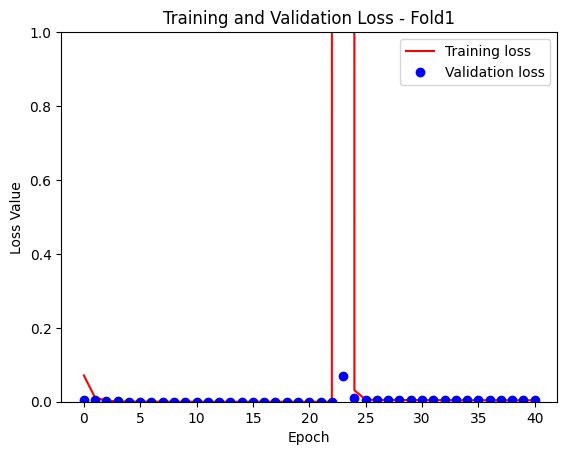

2024-11-06 17:59:26.855230: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 34990981120 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 836763648/12878086144
2024-11-06 17:59:26.855261: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      9785311232
InUse:                       270156046
MaxInUse:                  11510439514
NumAllocs:                       29555
MaxAllocSize:              10911555768
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-11-06 17:59:26.855336: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:62] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-11-06 17:59:26.855339: E external/local_xla/xla/stream_executo

Epoch 1/300


2024-11-06 18:00:04.401148: W external/local_xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 9.01GiB (9671712597 bytes) by rematerialization; only reduced to 9.71GiB (10424600592 bytes), down from 10.42GiB (11185902336 bytes) originally


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9746 - loss: 0.3080 - recall: 0.0038
Epoch 1: val_recall improved from -inf to 0.01485, saving model to UnetPLUS_test2fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 679ms/step - accuracy: 0.9750 - loss: 0.3040 - recall: 0.0039 - val_accuracy: 0.9993 - val_loss: 0.0044 - val_recall: 0.0149
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9993 - loss: 0.0046 - recall: 0.0465
Epoch 2: val_recall did not improve from 0.01485
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 622ms/step - accuracy: 0.9993 - loss: 0.0046 - recall: 0.0466 - val_accuracy: 0.9993 - val_loss: 0.0047 - val_recall: 0.0000e+00
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9994 - loss: 0.0046 - recall: 0.0214
Epoch 3: val_recall did not improve from 0.01485
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 629ms/step - accuracy: 0.9994 - loss: 0.0046 - recall: 0.0219 - val_accuracy: 0.9993 - val_loss: 0.0062 - val_recall: 0.0000e+00
Epoch 4/300
42/42 ━━━━━━━━━━━━━━━━

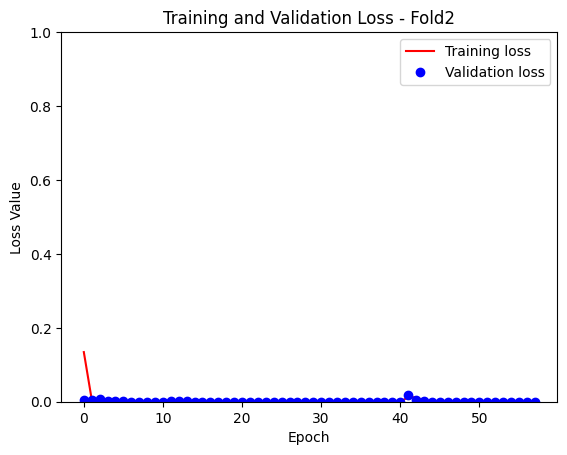

/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/skl

Epoch 1/300


2024-11-06 18:25:42.264710: W external/local_xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 9.01GiB (9671712597 bytes) by rematerialization; only reduced to 9.71GiB (10424600592 bytes), down from 10.42GiB (11185902336 bytes) originally


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.8994 - loss: 0.4815 - recall: 0.1214
Epoch 1: val_recall improved from -inf to 0.00000, saving model to UnetPLUS_test3fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 660ms/step - accuracy: 0.9012 - loss: 0.4739 - recall: 0.1192 - val_accuracy: 0.9994 - val_loss: 0.0051 - val_recall: 0.0000e+00
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9994 - loss: 0.0042 - recall: 5.6549e-05
Epoch 2: val_recall improved from 0.00000 to 0.00004, saving model to UnetPLUS_test3fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 616ms/step - accuracy: 0.9994 - loss: 0.0042 - recall: 6.2180e-05 - val_accuracy: 0.9994 - val_loss: 0.0033 - val_recall: 3.6399e-05
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9993 - loss: 0.0026 - recall: 0.0288
Epoch 3: val_recall improved from 0.00004 to 0.42187, saving model to UnetPLUS_test3fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 615ms/step - accuracy: 0.9993 - loss: 0.0026 - recall: 0.03

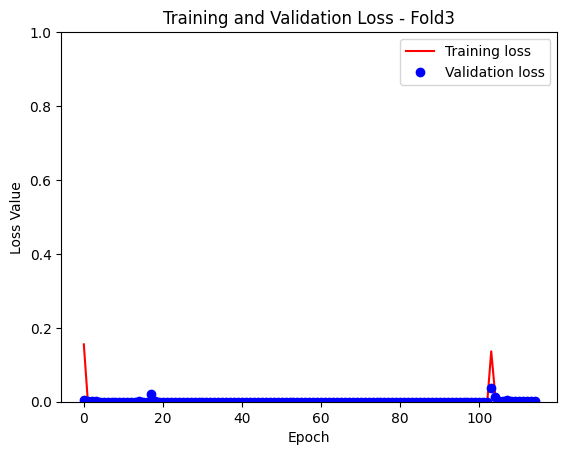

/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/skl

Epoch 1/300


2024-11-06 19:15:41.369765: W external/local_xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 9.01GiB (9671712597 bytes) by rematerialization; only reduced to 9.71GiB (10424600592 bytes), down from 10.42GiB (11185902336 bytes) originally


41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9242 - loss: 0.3205 - recall: 0.1460

2024-11-06 19:16:10.504291: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 44927287296 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 834666496/12878086144
2024-11-06 19:16:10.504324: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      9785311232
InUse:                      1015584790
MaxInUse:                  11623821450
NumAllocs:                      141412
MaxAllocSize:              10911555768
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-11-06 19:16:10.504713: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:62] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-11-06 19:16:10.504730: E external/local_xla/xla/stream_executo

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9256 - loss: 0.3152 - recall: 0.1433   

2024-11-06 19:17:42.418355: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 44245712896 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 832569344/12878086144
2024-11-06 19:17:42.418389: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      9785311232
InUse:                       880842810
MaxInUse:                  11623821450
NumAllocs:                      143069
MaxAllocSize:              10911555768
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-11-06 19:17:42.418790: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:62] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-11-06 19:17:42.418824: E external/local_xla/xla/stream_executo


Epoch 1: val_recall improved from -inf to 0.00000, saving model to UnetPLUS_test4fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9269 - loss: 0.3101 - recall: 0.1407 - val_accuracy: 0.9994 - val_loss: 0.0030 - val_recall: 0.0000e+00
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9993 - loss: 0.0032 - recall: 1.6408e-05
Epoch 2: val_recall improved from 0.00000 to 0.00574, saving model to UnetPLUS_test4fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 614ms/step - accuracy: 0.9993 - loss: 0.0031 - recall: 1.9338e-05 - val_accuracy: 0.9994 - val_loss: 0.0011 - val_recall: 0.0057
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9994 - loss: 0.0012 - recall: 0.0190
Epoch 3: val_recall improved from 0.00574 to 0.15207, saving model to UnetPLUS_test4fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 615ms/step - accuracy: 0.9994 - loss: 0.0012 - recall: 0.0194 - val_accuracy: 0.9995 - val_loss: 7.4276e-04 - val_recall: 0.1521
Epoch 4/300
42/42 ━━━━━━━━━

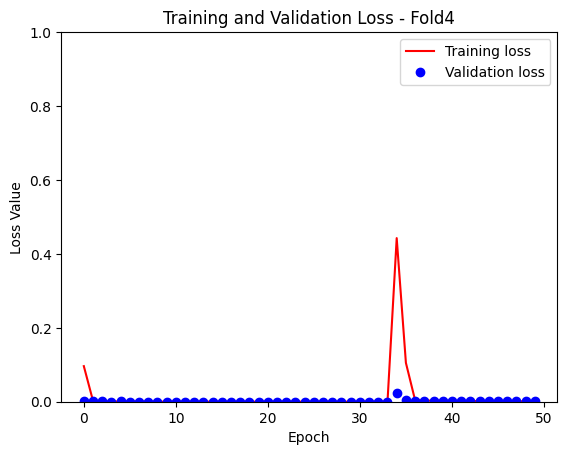

/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/skl

Epoch 1/300


2024-11-06 19:39:22.877007: W external/local_xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 9.01GiB (9671712597 bytes) by rematerialization; only reduced to 9.71GiB (10424600592 bytes), down from 10.42GiB (11185902336 bytes) originally


41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9559 - loss: 0.2041 - recall: 0.0643

2024-11-06 19:39:47.785472: W external/local_xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 9.01GiB (9672210671 bytes) by rematerialization; only reduced to 9.11GiB (9777401099 bytes), down from 9.78GiB (10498201595 bytes) originally


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9567 - loss: 0.2012 - recall: 0.0631
Epoch 1: val_recall improved from -inf to 0.00000, saving model to UnetPLUS_test5fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 660ms/step - accuracy: 0.9574 - loss: 0.1984 - recall: 0.0620 - val_accuracy: 0.9994 - val_loss: 0.0023 - val_recall: 0.0000e+00
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9993 - loss: 0.0061 - recall: 2.4785e-04
Epoch 2: val_recall improved from 0.00000 to 0.00054, saving model to UnetPLUS_test5fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 618ms/step - accuracy: 0.9993 - loss: 0.0061 - recall: 2.9552e-04 - val_accuracy: 0.9994 - val_loss: 0.0018 - val_recall: 5.3638e-04
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9994 - loss: 0.0020 - recall: 0.0565
Epoch 3: val_recall improved from 0.00054 to 0.46182, saving model to UnetPLUS_test5fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 618ms/step - accuracy: 0.9994 - loss: 0.0020 - recall: 0.05

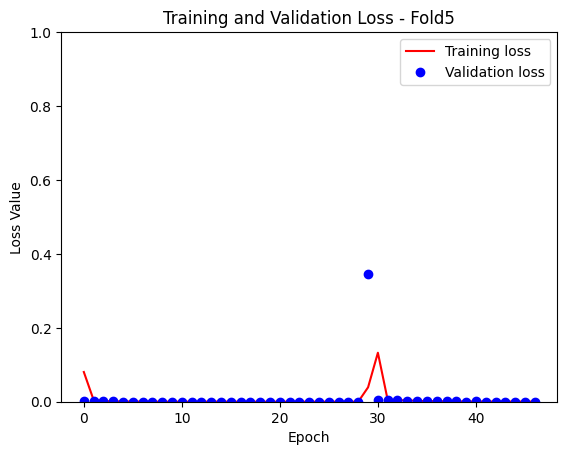

/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/skl

Accuracy: 0.9996881143574499+- 0.00044271339466730856
Jaccard: 0.5019366833193792+- 0.3531574587112322
Dice: 0.5800472349709022+- 0.3800492356019851
Precision: 0.6510765579401692+- 0.4213841166663674
Recall: 0.5687326235946406+- 0.3764239357981338


In [5]:

acc = []
jacc = []
f1 = []
prec = []
rec = []

kf = KFold(n_splits=k, shuffle=True, random_state=28)
f = 1

for train_ind, test_ind in kf.split(X):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
    
    model = unet_plus_plus()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name ='recall')])
    
    checkpoint_filepath = 'UnetPLUS_test' + str(f)+'fold.keras'
    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_recall',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=300, callbacks=callbacks)
    model.save('Unet++Modelo1.keras')
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    plt.figure()
    plt.plot( loss, 'r', label='Training loss')
    plt.plot( val_loss, 'bo', label='Validation loss')
    plt.title('Training and Validation Loss - Fold' + str(f))
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc.append(accuracy_score(sample_mask, predicted_mask))
        jacc.append(jaccard_score(sample_mask, predicted_mask))
        f1.append(f1_score(sample_mask, predicted_mask))
        prec.append(precision_score(sample_mask, predicted_mask))
        rec.append(recall_score(sample_mask, predicted_mask))

    del model 

    tf.keras.backend.clear_session()

    f+=1
    
print("Accuracy: "+ str(np.mean(acc)) + "+- " + str(np.std(acc)))
print("Jaccard: "+ str(np.mean(jacc)) + "+- " + str(np.std(jacc)))
print("Dice: "+ str(np.mean(f1)) + "+- " + str(np.std(f1)))
print("Precision: "+ str(np.mean(prec)) + "+- " + str(np.std(prec)))
print("Recall: "+ str(np.mean(rec)) + "+- " + str(np.std(rec)))

In [8]:
print("Accuracy: "+ str(np.mean(acc)) + "+- " + str(np.std(acc)))
print("Jaccard: "+ str(np.mean(jacc)) + "+- " + str(np.std(jacc)))
print("Dice: "+ str(np.mean(f1)) + "+- " + str(np.std(f1)))
print("Precision: "+ str(np.mean(prec)) + "+- " + str(np.std(prec)))
print("Recall: "+ str(np.mean(rec)) + "+- " + str(np.std(rec)))

Accuracy: nan+- nan
Jaccard: nan+- nan
Dice: nan+- nan
Precision: nan+- nan
Recall: nan+- nan


/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


f = 0
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    acc= []
    jacc = []
    f1 = []
    prec = []
    rec = []
    
    model = tf.keras.models.load_model('UnetPLUS_test'+str(f+1)+'fold.keras')

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc.append(accuracy_score(sample_mask, predicted_mask))
        jacc.append(jaccard_score(sample_mask, predicted_mask))
        f1.append(f1_score(sample_mask, predicted_mask))
        prec.append(precision_score(sample_mask, predicted_mask))
        rec.append(recall_score(sample_mask, predicted_mask))

    acc_mean_fold.append(np.mean(acc))
    acc_std_fold.append(np.std(acc))
    jacc_mean_fold.append(np.mean(jacc))
    jacc_std_fold.append(np.std(jacc))
    f1_mean_fold.append(np.mean(f1))
    f1_std_fold.append(np.std(f1))
    prec_mean_fold.append(np.mean(prec))
    prec_std_fold.append(np.std(prec))
    rec_mean_fold.append(np.mean(rec))
    rec_std_fold.append(np.std(rec))
    
    print("Model - Fold" + str(f+1)+ "Accuracy: " + str(acc_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Jaccard: " + str(jacc_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Dice: " + str(f1_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Precision: " + str(prec_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Recall: " + str(rec_mean_fold[-1]))

    f += 1

k-fold:  20%|███████████████▍                                                             | 1/5 [00:39<02:39, 39.78s/it]

Model - Fold1Accuracy: 0.9999207087925502
Model - Fold1Jaccard: 0.8735519518220314
Model - Fold1Dice: 0.9255335837372546
Model - Fold1Precision: 0.9001143032568711
Model - Fold1Recall: 0.9667316714583478


k-fold:  40%|██████████████████████████████▊                                              | 2/5 [01:18<01:57, 39.13s/it]

Model - Fold2Accuracy: 0.9999477976844424
Model - Fold2Jaccard: 0.8978951851054056
Model - Fold2Dice: 0.9438765863647921
Model - Fold2Precision: 0.9134472841146591
Model - Fold2Recall: 0.9830916927916181


k-fold:  60%|██████████████████████████████████████████████▏                              | 3/5 [01:57<01:18, 39.02s/it]

Model - Fold3Accuracy: 0.9999204817272368
Model - Fold3Jaccard: 0.8337698688483174
Model - Fold3Dice: 0.901263349444457
Model - Fold3Precision: 0.847072739492404
Model - Fold3Recall: 0.9852043509904407


k-fold:  80%|█████████████████████████████████████████████████████████████▌               | 4/5 [02:36<00:38, 38.97s/it]

Model - Fold4Accuracy: 0.999943099335996
Model - Fold4Jaccard: 0.8785265553058331
Model - Fold4Dice: 0.9317409811404084
Model - Fold4Precision: 0.892042696391498
Model - Fold4Recall: 0.9845074295390253


/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
k-fold: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [03:14<00:00, 38.85s/it]

Model - Fold5Accuracy: 0.9999356298389549
Model - Fold5Jaccard: 0.8623549066791603
Model - Fold5Dice: 0.9160216415700596
Model - Fold5Precision: 0.8746722363414318
Model - Fold5Recall: 0.9803640632354588


In [10]:
print("Accuracy: "+ str(np.mean(acc_mean_fold)*100) + " +- " + str(np.std(acc_std_fold)*100))
print("Jaccard: "+ str(np.mean(jacc_mean_fold)*100) + " +- " + str(np.std(jacc_std_fold)*100))
print("Dice: "+ str(np.mean(f1_mean_fold)*100) + " +- " + str(np.std(f1_std_fold)*100))
print("Precision: "+ str(np.mean(prec_mean_fold)*100) + " +- " + str(np.std(prec_std_fold)*100))
print("Recall: "+ str(np.mean(rec_mean_fold)*100) + " +- " + str(np.std(rec_std_fold)*100))

Accuracy: 99.99335434758359 +- 0.005759900463742796
Jaccard: 86.92196935521496 +- 2.4759914989956213
Dice: 92.36872284513943 +- 2.773047213956485
Precision: 88.5469851919373 +- 2.6339512069605444
Recall: 97.9979841602978 +- 1.268643850413476


In [11]:
best_model = tf.keras.models.load_model('UnetPLUS_test2fold.keras')

In [12]:

kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == 1:
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


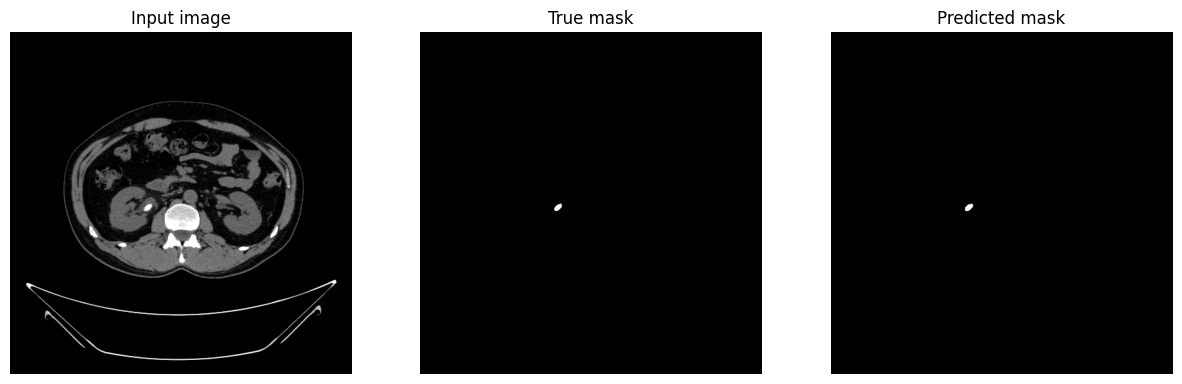

Accuracy: 0.9999732971191406
Jaccard: 0.9222222222222223
Dice: 0.9595375722543353
Precision: 0.9222222222222223
Recall: 1.0


In [19]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))

print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))

In [ ]:
predicted_mask.shape